In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from datetime import datetime


from functions.data_loading import get_flight_persistence, get_condensed_distance_matrix, get_data_range, get_filtered_data_range
from functions.objects import PersistenceData
from functions.plotting import plot_cluster_scatters, plot_cluster_pers_diagrams
from functions.hartigan import hartigan_index

from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter

sys.setrecursionlimit(10000)

In [2]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
#file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
way_1_trees, way_1_paths, file_name = get_flight_persistence(None, file_name, load_results=True)

8054 before, 6948 after

In [3]:
origin = "bergen"
destination = "oslo"
#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
#filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/bergen-oslo-2023-01-01-2024-01-01.pkl"
way_2_trees, way_2_paths, file_name = get_flight_persistence(None, file_name, load_results=True)

7779 before, 6866 after

In [4]:
trees = way_1_trees + way_2_trees
paths = way_1_paths + way_2_paths

condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name, load_results=True)
distance_matrix = squareform(condensed_distance_matrix)

pers_data = PersistenceData(trees, paths, "LL")

clusterings = {}

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# distance_matrix should be a 2D NumPy array
tsne = TSNE(metric='precomputed', perplexity=20, random_state=41, init='random')
embedding = tsne.fit_transform(distance_matrix)

C:\Users\tobso\AppData\Local\Temp\ipykernel_5100\1081868444.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


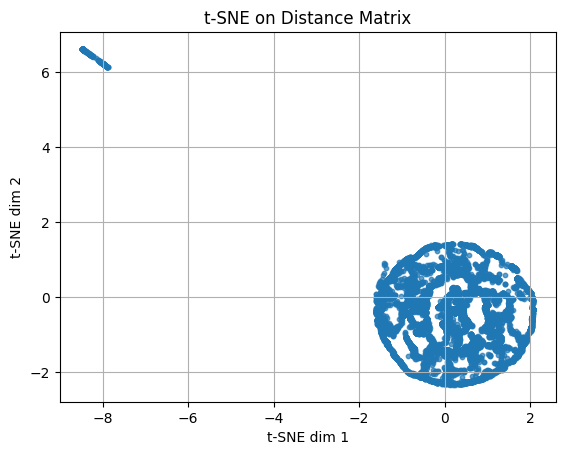

In [6]:
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.7)
ax.set_title("t-SNE on Distance Matrix")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
ax.grid(True)
fig.show()
fig.savefig(f"./Thesis Plots/Experiment1/TSNE_plot.svg", format="svg", dpi=1000, bbox_inches='tight')

In [7]:
def select_k_by_hartigan(clusterer_factory,data, distances = None, start_k=5, max_k=50, threshold=10.0, squared=False):
    """
    Returns (k_star, labels_k_star, history) where history is a list of (k, H_k).
    Chooses the *first* k with H_k <= threshold; if none, falls back to argmin(H_k).
    """
    history = []
    k = start_k
    if distances is None:
        distances = euclidean_distances(data)

    labels_k = clusterer_factory(k).fit_predict(data)

    while k + 1 <= max_k:
        labels_k1 = clusterer_factory(k + 1).fit_predict(data)

        Hk = hartigan_index(labels_k, labels_k1, distances, squared=squared)
        history.append((k, float(Hk)))

        if np.isfinite(Hk) and Hk <= threshold:
            return k, labels_k, history

        # roll forward
        k += 1
        labels_k = labels_k1

    # Fallback: pick k with minimal finite H_k (could be negative)
    finite_hist = [(kk, hh) for kk, hh in history if np.isfinite(hh)]
    if finite_hist:
        k_best, _ = min(finite_hist, key=lambda t: t[1])
        labels_best = clusterer_factory(k_best).fit_predict(data)
        return k_best, labels_best, history

    return None, None, history  # nothing usable

In [ ]:
def Agglomerative_factory(k, *, use_metric=True):
    # use_metric=True assumes sklearn >= 1.2; otherwise switch to affinity='precomputed'
    kwargs = dict(n_clusters=k, linkage="complete")
    if use_metric:
        kwargs["metric"] = "precomputed"
    else:
        kwargs["affinity"] = "precomputed"
    return AgglomerativeClustering(**kwargs)

def KMedoids_factory(k, *, random_state=42):
    return KMedoids(
        n_clusters=k,
        metric="precomputed",
        init="k-medoids++",
        random_state=random_state,
    )

for name, factory in [
    ("Agglomerative", lambda k: Agglomerative_factory(k, use_metric=True)),
    ("KMedoids",      lambda k: KMedoids_factory(k, random_state=0)),
]:
    k_star, labels, history = select_k_by_hartigan(factory, distance_matrix, distances=distance_matrix, start_k=5, max_k=50, threshold=10.0, squared=False)

    if labels is not None:
        clusterings[name] = labels
        print(f"{name}: chosen k = {k_star} (first H_k <= 10)")
    else:
        print(f"{name}: no usable Hartigan value within range.")


In [15]:
def KMeans_factory(k, random_state=42):
    return KMeans(
        n_clusters=k,
        init="k-means++",
        random_state=random_state,
    )

# ---- run both methods --------------------------------------------------------

for name, factory in [("KMeans", lambda k: KMeans_factory(k, random_state=0))]:
    k_star, labels, history = select_k_by_hartigan(factory, pers_data.stats, start_k=5, max_k=50, threshold=10.0, squared=False)

    if labels is not None:
        clusterings[name] = labels
        print(f"{name}: chosen k = {k_star} (first H_k <= 10)")
    else:
        print(f"{name}: no usable Hartigan value within range.")

KMeans: chosen k = 20 (first H_k <= 10)


In [16]:
for key, clustering in clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Kmeans:
0: 13694 | 1: 1 | 2: 1 | 3: 3 | 4: 3 | 5: 5 | 6: 1 | 7: 1 | 8: 9 | 9: 1 | 10: 18 | 11: 1 | 12: 1 | 13: 4 | 14: 7 | 15: 51 | 16: 2 | 17: 1 | 18: 3 | 19: 7


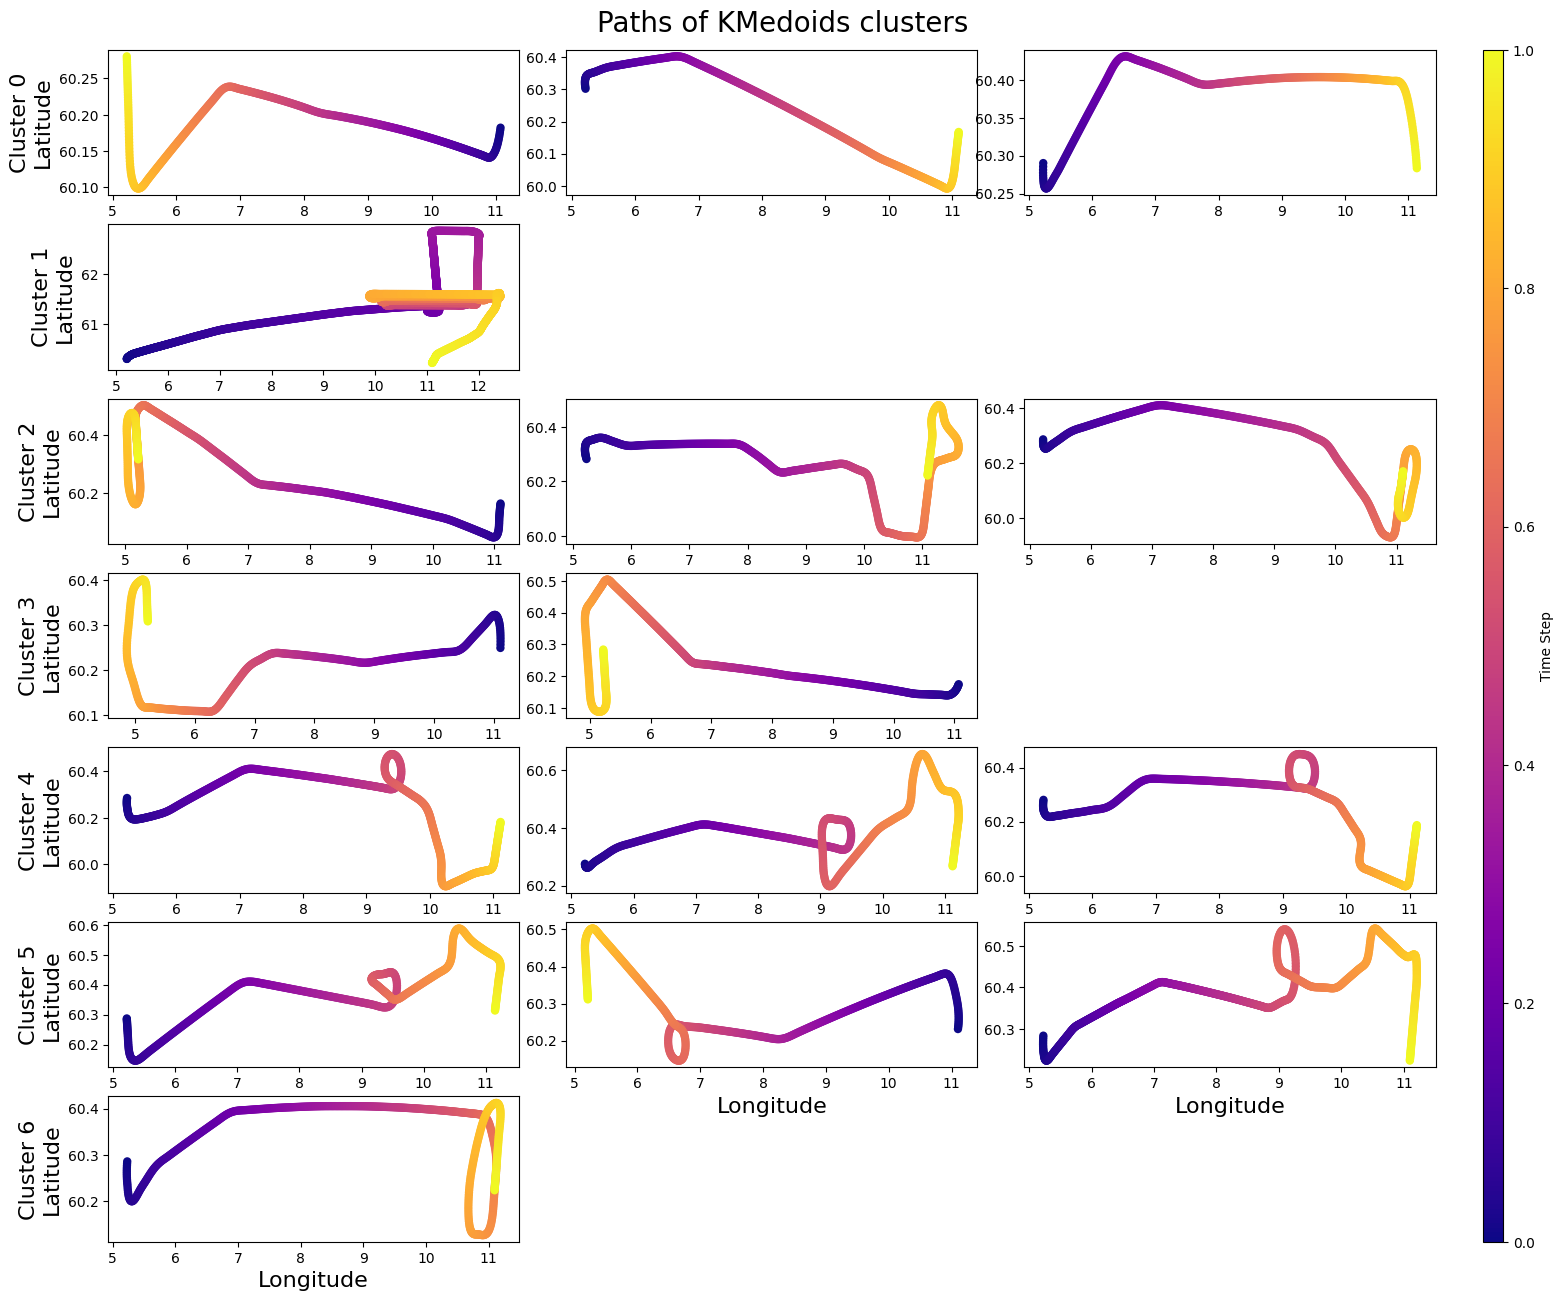

In [21]:
cluster_methods = ["Agglomerative", "KMedoids"]
sample_count = 3
method = cluster_methods[1]


clustering = distance_based_clusterings[method]

fig = plot_cluster_scatters(clustering, pers_data, method, sample_count)
fig.savefig(f"./Thesis Plots/Experiment1/distance_cluster_scatters.svg", format="svg", dpi=1000, bbox_inches='tight')

#fig = plot_cluster_pers_diagrams(clustering, pers_data, method, sample_count)
#fig.savefig(f"./Thesis Plots/Experiment1/distance_cluster_persistence_diagrams.svg", format="svg", dpi=1000, bbox_inches='tight')

C:\Users\tobso\AppData\Local\Temp\ipykernel_18796\1397225451.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


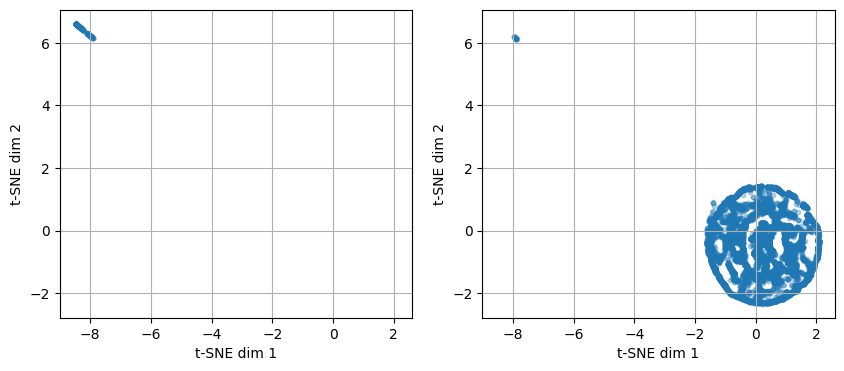

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
cluster = 20
ax[0].scatter(embedding[clustering != cluster, 0], embedding[clustering != cluster, 1], s=10, alpha=0.3)
ax[0].set_xlabel("t-SNE dim 1")
ax[0].set_ylabel("t-SNE dim 2")
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)
ax[0].grid(True)

ax[1].scatter(embedding[clustering == cluster, 0], embedding[clustering == cluster, 1], s=10, alpha=0.3)
ax[1].set_xlabel("t-SNE dim 1")
ax[1].set_ylabel("t-SNE dim 2")
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)
ax[1].grid(True)
fig.show()

fig.savefig(f"./Thesis Plots/Experiment1/distance_cluster_TSNE.svg", format="svg", dpi=300, bbox_inches='tight')

In [19]:
K_Means = KMeans(n_clusters=5)
optics = OPTICS(n_jobs=6)

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

for cluster_method in [dbscan, optics, K_Means]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(data)
    normal_clusterings[method_name] = clustering

KeyboardInterrupt: 

In [15]:
for key, clustering in normal_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Dbscan:
-1: 188 | 0: 13624 | 1: 2
Optics:
-1: 129 | 0: 13635 | 1: 14 | 2: 8 | 3: 5 | 4: 5 | 5: 7 | 6: 11
Kmeans:
0: 13756 | 1: 5 | 2: 51 | 3: 1 | 4: 1


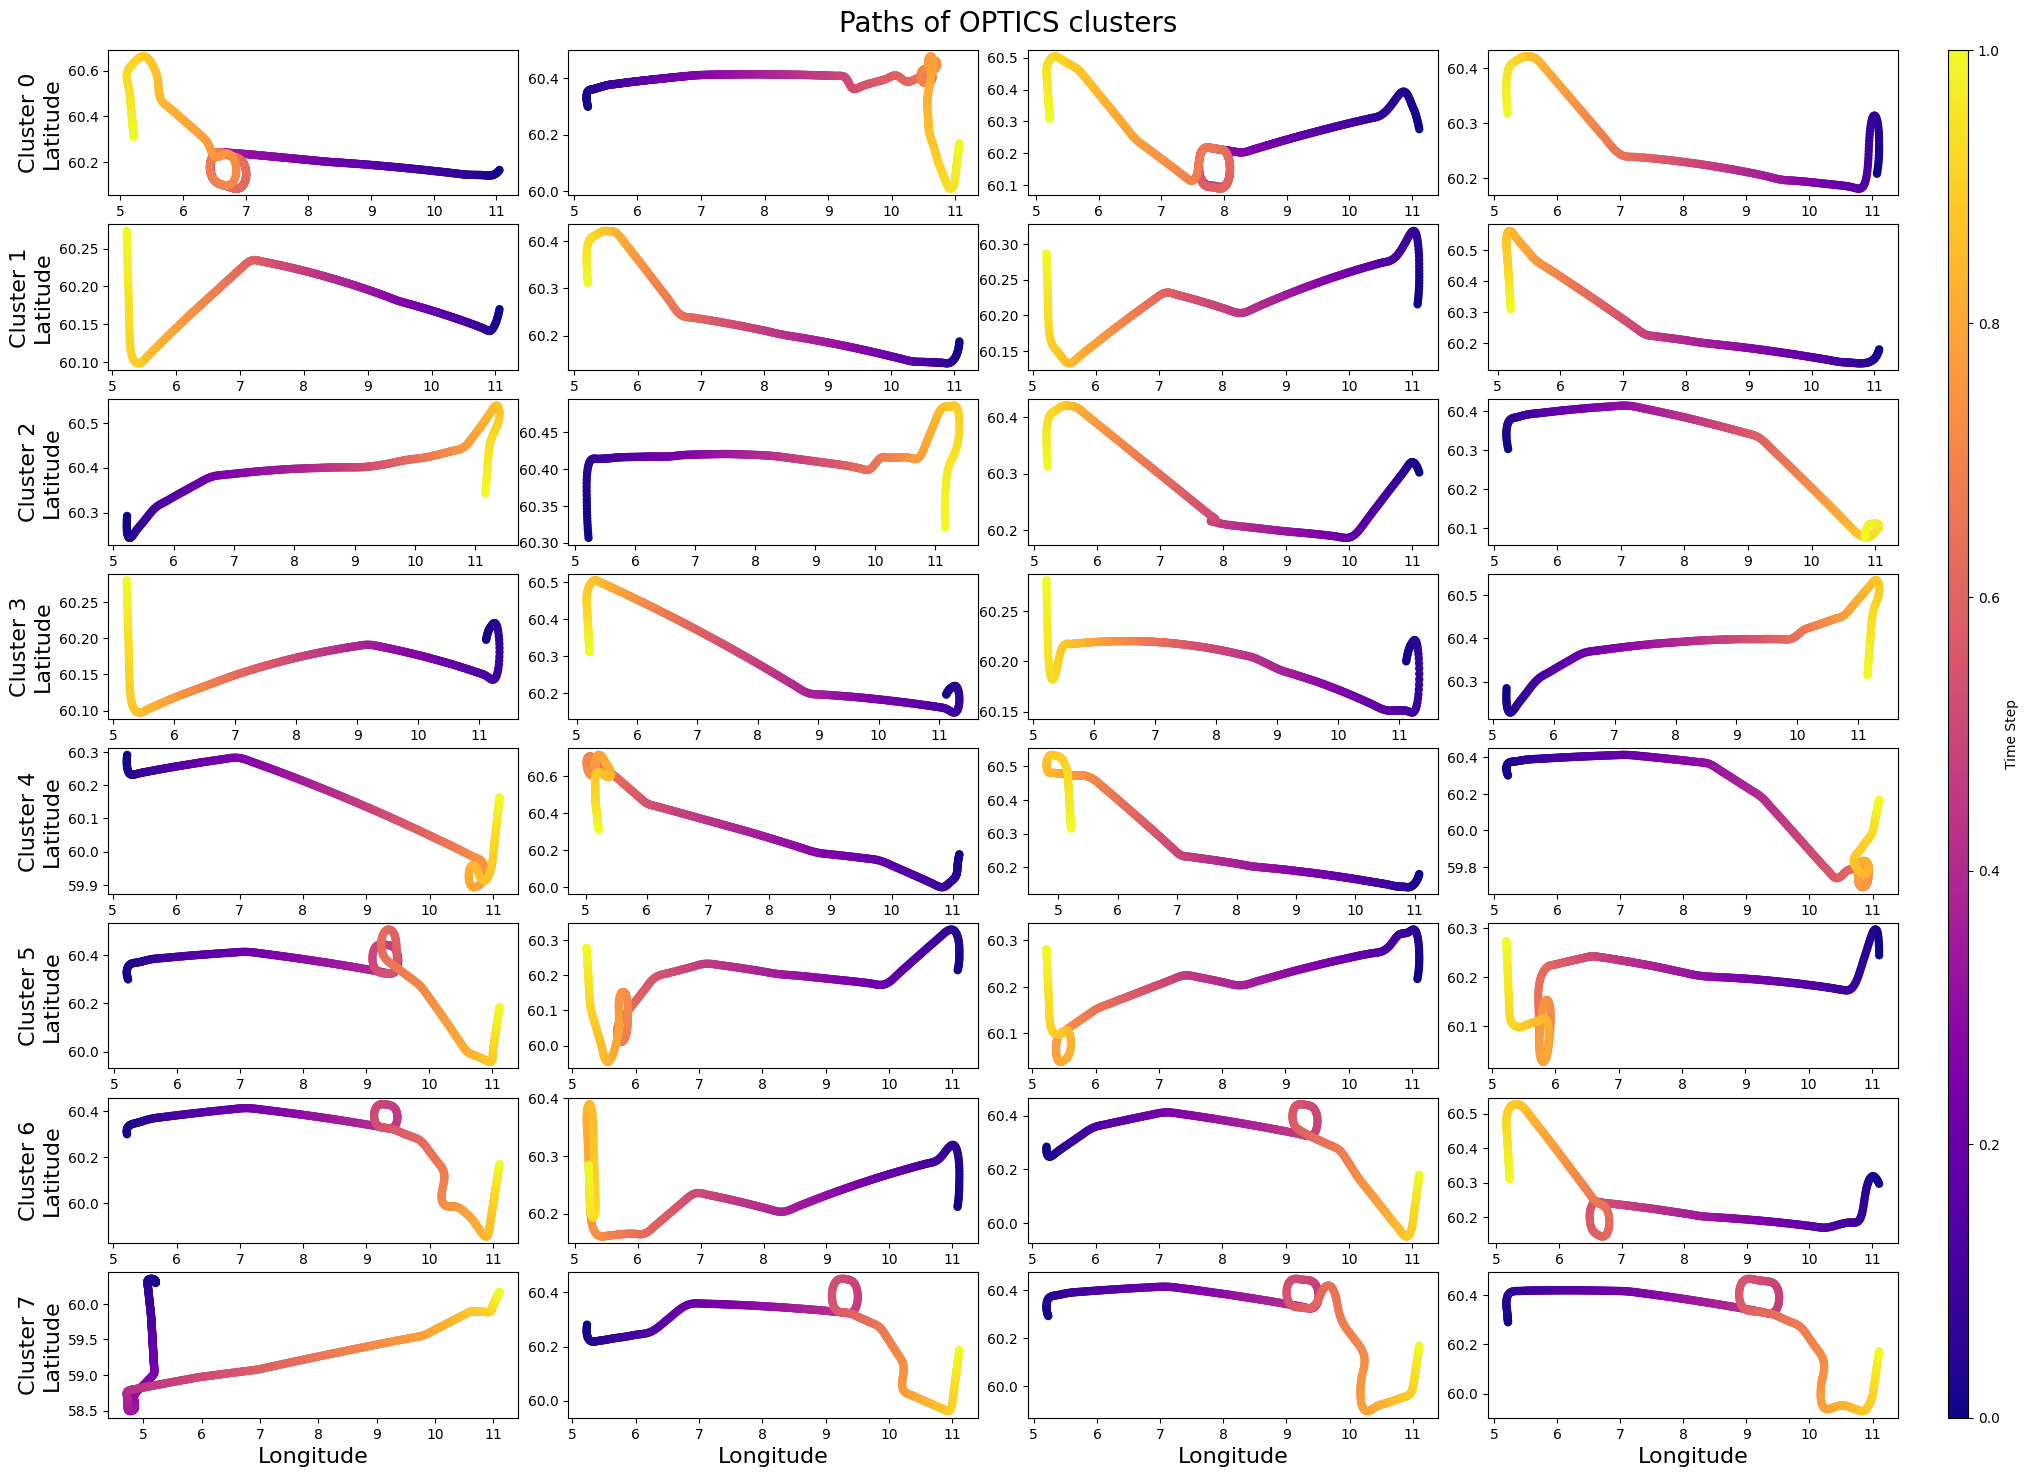

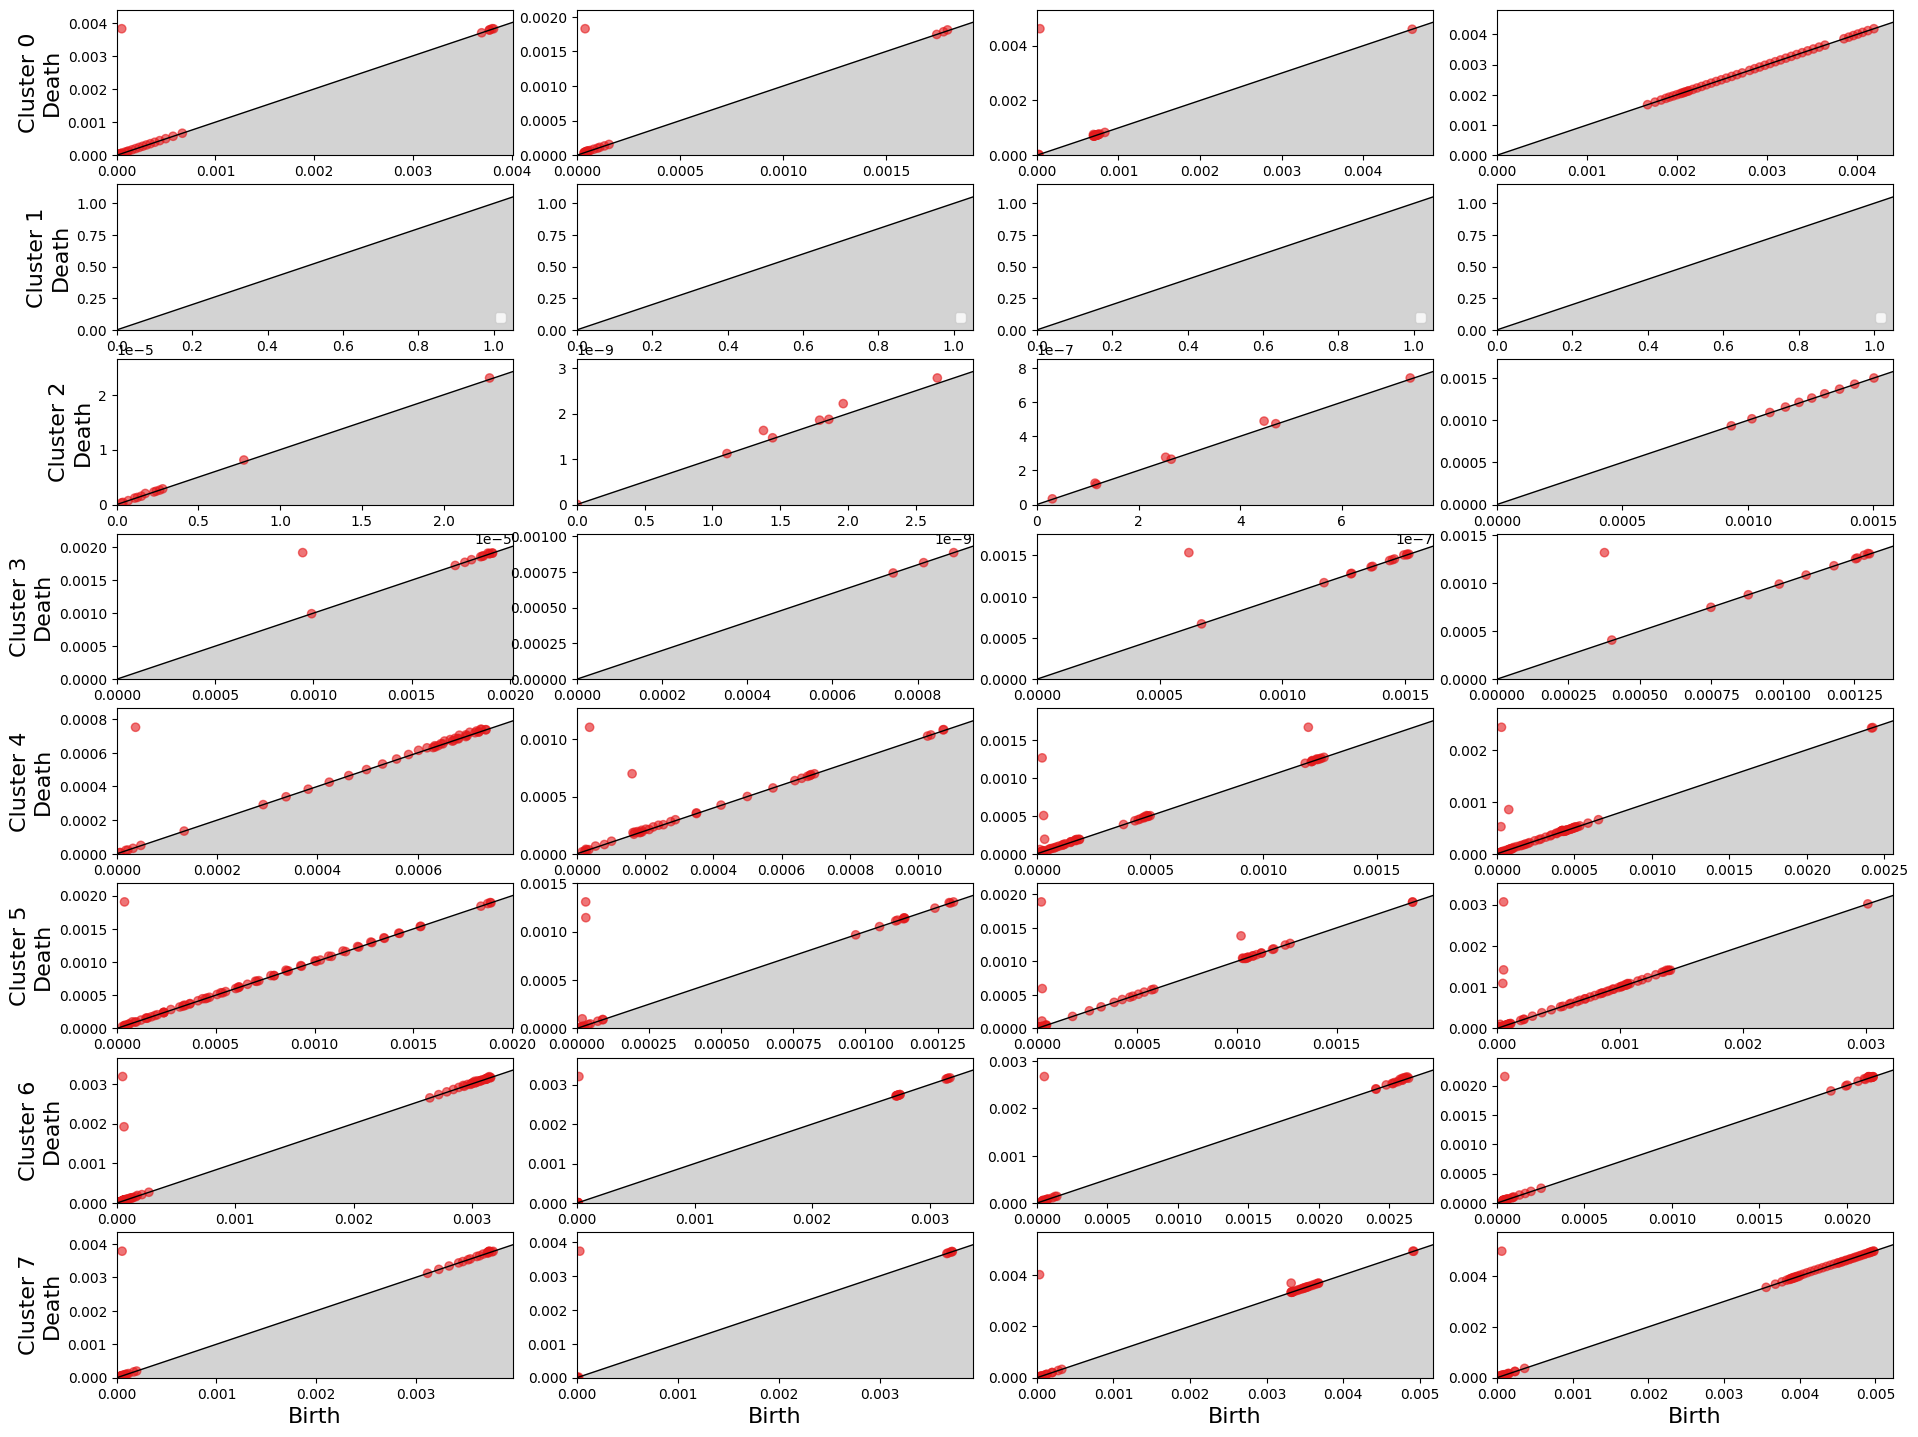

In [31]:
cluster_methods = ["DBSCAN", "KMeans"]
sample_count = 4
method = cluster_methods[1]

clustering = normal_clusterings[method]

#fig = plot_cluster_scatters(clustering, pers_data, method, sample_count)
#fig.savefig(f"./Thesis Plots/Experiment1/metric_cluster_scatters.svg", format="svg", dpi=1000, bbox_inches='tight')

#fig = plot_cluster_pers_diagrams(clustering, pers_data, method, sample_count)
#fig.savefig(f"./Thesis Plots/Experiment1/metric_cluster_persistence_diagrams.svg", format="svg", dpi=1000, bbox_inches='tight')

C:\Users\tobso\AppData\Local\Temp\ipykernel_18796\1322855663.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


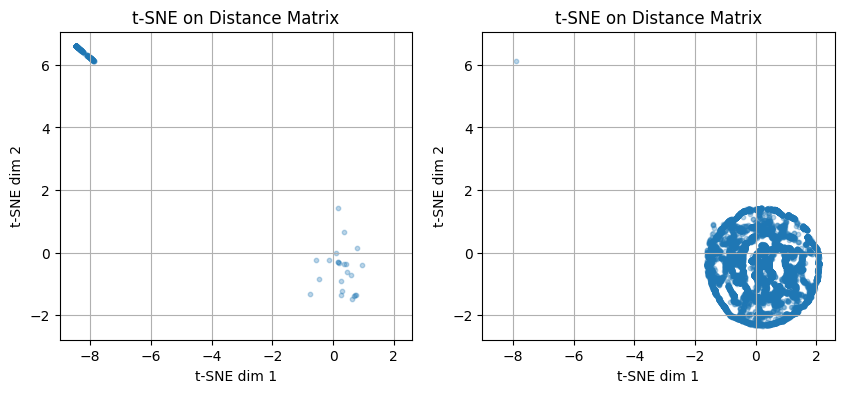

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
cluster = 0
ax[0].scatter(embedding[clustering != cluster, 0], embedding[clustering != cluster, 1], s=10, alpha=0.3)
ax[0].set_title("t-SNE on Distance Matrix")
ax[0].set_xlabel("t-SNE dim 1")
ax[0].set_ylabel("t-SNE dim 2")
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)
ax[0].grid(True)

ax[1].scatter(embedding[clustering == cluster, 0], embedding[clustering == cluster, 1], s=10, alpha=0.3)
ax[1].set_title("t-SNE on Distance Matrix")
ax[1].set_xlabel("t-SNE dim 1")
ax[1].set_ylabel("t-SNE dim 2")
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)
ax[1].grid(True)
fig.show()

fig.savefig(f"./Thesis Plots/Experiment1/metric_cluster_TSNE.svg", format="svg", dpi=1000, bbox_inches='tight')

In [30]:
distance_based_clusterings["LINKAGE"] = fcluster(Z, t=33, criterion='maxclust', depth=2)
for key, clustering in distance_based_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Linkage:
1: 1 | 2: 1 | 3: 2 | 4: 2 | 5: 3 | 6: 1 | 7: 2 | 8: 13769 | 9: 1 | 10: 1 | 11: 1 | 12: 1 | 13: 1 | 14: 1 | 15: 2 | 16: 1 | 17: 1 | 18: 1 | 19: 1 | 20: 1 | 21: 1 | 22: 1 | 23: 5 | 24: 3 | 25: 1 | 26: 2 | 27: 1 | 28: 1 | 29: 1 | 30: 1 | 31: 1 | 32: 1 | 33: 1
